# The Helmholtz equation

Author: Igor A. Baratta

In this tutorial, we will learn:

 - How to solve PDEs with complex-valued fields,
 - How to import and use high-order meshes from Gmsh,
 - How to use high order discretizations,
 - How to use UFL expressions.

## Problem statement
We will solve the Helmholtz equation subject to a first order absorbing boundary condition:

$$
\begin{align*}
\Delta u + k^2 u &= 0 \qquad \text{in } \Omega,\\
\nabla u \cdot \mathbf{n} - jku &= g \qquad \text{on } \partial\Omega.
\end{align*}
$$

where $k$ is a pieciwise constant wavenumber, and $g$ is the boundary source term computed as:

$$g = \nabla u_i \cdot \mathbf{n} - jku_i$$

and $u_i$ is the incoming plane wave. 

In [1]:
import numpy as np
from mpi4py import MPI

import dolfinx
import ufl

This code is only meant to be executed with complex-valued degrees of freedom. To be able to solve such problems, we use the complex build of PETSc.

In [2]:
import sys
from petsc4py import PETSc

if not np.issubdtype(PETSc.ScalarType, np.complexfloating):
    print("This tutorial requires complex number support")
    sys.exit(0)
else:
    print(f"Using {PETSc.ScalarType}.")

Using <class 'numpy.complex128'>.


## Defining model parameters

In [3]:
# wavenumber in free space (air)
k0 = 10 * np.pi

# Corresponding wavelength
lmbda = 2 * np.pi / k0

# Polynomial degree
degree = 6

# Mesh order
mesh_order = 2

## Interfacing with GMSH

We will use [Gmsh](http://gmsh.info/) to generate the computational domain (mesh) for this example. As long as Gmsh has been installed (including its Python API), DOLFINx supports direct input of Gmsh models (generated on one process). DOLFINx will then in turn distribute the mesh over all processes in the communicator passed to `dolfinx.io.gmshio.model_to_mesh`.

The function `generate_mesh` creates a Gmsh model on rank 0 of `MPI.COMM_WORLD`.The function `generate_mesh` creates a Gmsh model on rank 0 of `MPI.COMM_WORLD`.

In [4]:
from dolfinx.io import gmshio
from mesh_generation import generate_mesh

# MPI communicator
comm = MPI.COMM_WORLD

file_name = "domain.msh"
generate_mesh(file_name, lmbda, order=mesh_order)
mesh, cell_tags, _ = gmshio.read_from_msh(file_name, comm, 
                                          rank = 0, gdim = 2)

Info    : Reading 'domain.msh'...
Info    : 15 entities
Info    : 2985 nodes
Info    : 1444 elements
Info    : Done reading 'domain.msh'


## Material parameters

In this problem, the wave number in the different parts of the domain depends on cell markers, inputted through `cell_tags`.
We use the fact that a Discontinuous Lagrange space of order 0 (cell-wise piecewise constants) has a one-to-one mapping with the cells local to the process.

In [5]:
W = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))
k = dolfinx.fem.Function(W)
k.x.array[:] = k0
k.x.array[cell_tags.find(1)] = 3*k0

In [6]:
import pyvista
import matplotlib.pyplot as plt
from dolfinx.plot import create_vtk_mesh

# Start virtual framebuffer for plotting
pyvista.start_xvfb(0.5)
pyvista.set_jupyter_backend("pythreejs")
pyvista.set_plot_theme("paraview")

sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
            position_x=0.1, position_y=0.8, width=0.8, height=0.1)

def plot_function(grid, name, show_mesh=False):

    grid.set_active_scalars(name)
    plotter = pyvista.Plotter()
    renderer = plotter.add_mesh(grid, show_edges=False, scalar_bar_args=sargs)
    if show_mesh:
        V = dolfinx.fem.FunctionSpace(mesh, ("Lagrange", 1))
        grid_mesh = pyvista.UnstructuredGrid(*create_vtk_mesh(V))
        renderer = plotter.add_mesh(grid_mesh, style="wireframe", line_width=0.1, color="k")
        plotter.view_xy()
        plotter.camera.zoom(2)

    img = plotter.screenshot(f"{name}.png", transparent_background=True)
    plt.axis("off")
    plt.gcf().set_size_inches(15,15)
    fig = plt.imshow(img)

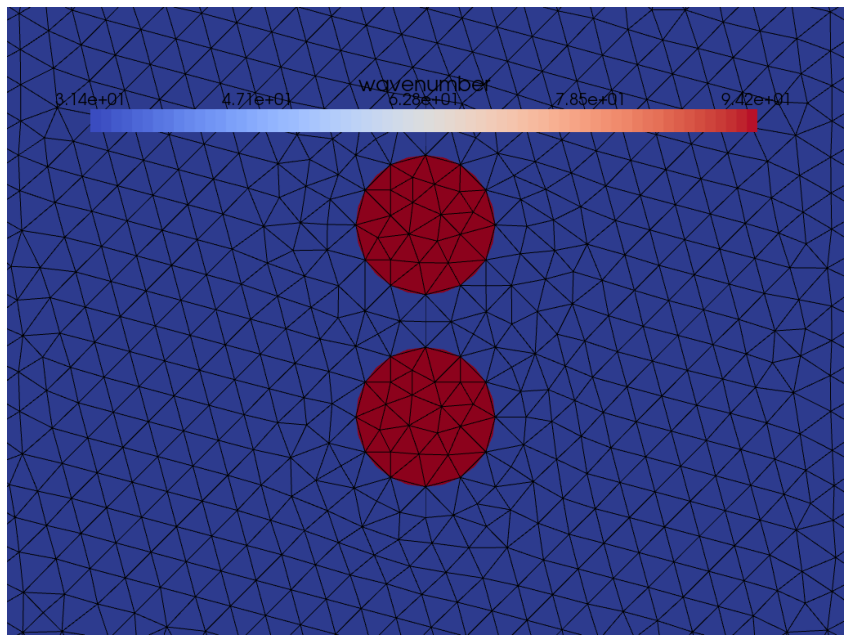

In [7]:
grid = pyvista.UnstructuredGrid(*create_vtk_mesh(mesh))
grid.cell_data["wavenumber"] = k.x.array.real
plot_function(grid, "wavenumber", show_mesh=True)

## Boundary source term

$$g = \nabla u_{inc} \cdot \mathbf{n} - \mathrm{j}ku_{inc}$$


Next, we define the boundary source term, by using `ufl.SpatialCoordinate`. When using this function, all quantities using this expression will be evaluated at quadrature points.

In [8]:
n = ufl.FacetNormal(mesh)
x = ufl.SpatialCoordinate(mesh)
uinc = ufl.exp(-1j * k * x[0])
g = ufl.dot(ufl.grad(uinc), n) + 1j * k * uinc

## Variational form

Next, we can define the variational problem, using a 4th order Lagrange space. Note that as we are using complex valued functions, we have to use the appropriate inner product, see [DOLFINx tutorial: Complex numbers](https://jorgensd.github.io/dolfinx-tutorial/chapter1/complex_mode.html) for more information.

$$ -\int_\Omega \nabla u \cdot \nabla \bar{v} ~ dx + \int_\Omega k^2 u \,\bar{v}~ dx - j\int_{\partial \Omega} ku  \bar{v} ~ ds = \int_{\partial \Omega} g \, \bar{v}~ ds \qquad \forall v \in \widehat{V}. $$

In [9]:
element = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), degree)
V = dolfinx.fem.FunctionSpace(mesh, element)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [10]:
a = - ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx \
    + k**2 * ufl.inner(u, v) * ufl.dx \
    - 1j * k * ufl.inner(u, v) * ufl.ds
L = ufl.inner(g, v) * ufl.ds

## Linear solver

Next, we will solve the problem using a direct solver (LU).

In [11]:
opt = {"ksp_type": "preonly", "pc_type": "lu"}
problem = dolfinx.fem.petsc.LinearProblem(a, L, petsc_options=opt)
uh = problem.solve()
uh.name = "u"

## Postprocessing

### Visualising using PyVista

In [12]:
topology, cells, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.point_data["Re(u)"] = uh.x.array.real
grid.point_data["Im(u)"] = uh.x.array.imag

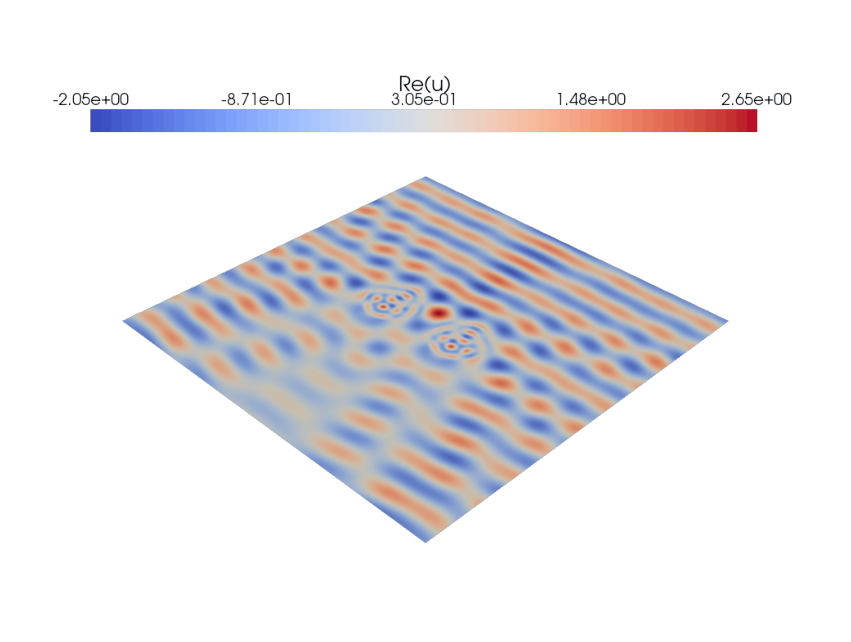

In [13]:
plot_function(grid, "Re(u)")

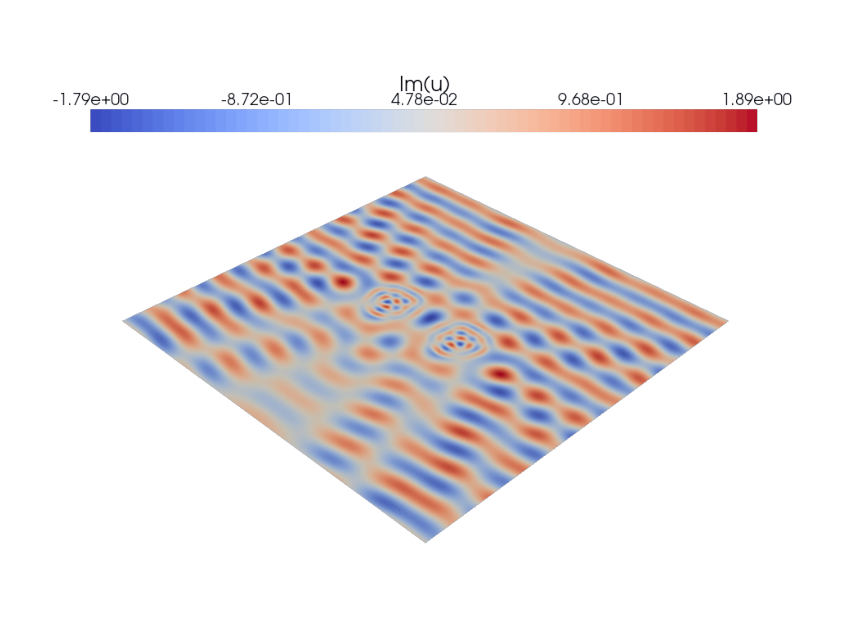

In [14]:
plot_function(grid, "Im(u)")

### Post-processing with Paraview

In [15]:
from dolfinx.io import XDMFFile, VTXWriter
u_abs = dolfinx.fem.Function(V, dtype=np.float64)
u_abs.x.array[:] = np.abs(uh.x.array)

### XDMFFile

In [16]:
# XDMF writes data to mesh nodes
with XDMFFile(comm, "out.xdmf", "w") as file:
    file.write_mesh(mesh)
    file.write_function(u_abs)

<img src="./xdmf.png" alt="xdmf" class="bg-primary mb-1" width="500px">

### VTXWriter

In [17]:
# VTX can write higher order functions
with VTXWriter(comm, "out_high_order.bp", [u_abs]) as f:
    f.write(0.0)

<img src="./vtx.png" alt="vtx" class="bg-primary mb-1" width="500px">